In [2]:
# edstays in full (race reclass, need to find)
# cardiac_arrest variable from triage /alongisde triage
# vital signs (last value, or median if not taken)

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Capstone/

Mounted at /content/drive
/content/drive/MyDrive/Capstone


In [138]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.3 MB/s 


In [134]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score

from xgboost import XGBClassifier

import shap

In [61]:
edstays = pd.read_csv('edstays.csv')
triage = pd.read_csv('triage.csv')
vitals = pd.read_csv('vitalsign.csv')

print(edstays.shape)
print(triage.shape)
print(vitals.shape)
print(vitals.columns)

(447712, 9)
(447712, 11)
(1646976, 11)
Index(['subject_id', 'stay_id', 'charttime', 'temperature', 'heartrate',
       'resprate', 'o2sat', 'sbp', 'dbp', 'rhythm', 'pain'],
      dtype='object')


In [62]:
def race_class(x):
  if 'WHITE' in x or 'PORTU' in x:
    return 'WHITE'
  elif 'BLACK' in x:
    return 'BLACK'
  elif 'LATIN' in x:
    return 'LATINO'
  elif 'ASIAN' in x:
    return 'ASIAN'
  else:
    return 'OTHER'

edstays['race_class'] = edstays.race.apply(race_class)

edstays_sub = edstays[edstays.disposition.isin(['ADMITTED','TRANSFER','EXPIRED'])]
edstays_sub.loc[edstays_sub.disposition=='TRANSFER', 'disposition'] = 'ADMITTED'

def cardiac_arrest(x):
  try:
    x = str(x)
    if 'cardiac' in x.lower() or 'arrest' in x.lower():
      return 1
    else:
      return 0
  except:
    return 0

triage['cardiac_arrest'] = triage.chiefcomplaint.apply(cardiac_arrest)
triage['cardiac_arrest'].value_counts()

def rescale_temp(x):
    if x > 200:
        return x/10
    else:
        return x

triage['temperature'] = [rescale_temp(x) for x in triage['temperature']]

def rescale_heart(x):
    if x > 300:
        return x / 100
    else:
        return x
    
triage['heartrate'] = [rescale_heart(x) for x in triage['heartrate']]

def rescale_pain(x):
    try:
        x = int(x)
        if x > 100:
            return 10
        elif x > 10:
            return x/10
        elif x < 0:
            return 0
        else:
            return x
    except:
        return None
    
triage['pain'] = [rescale_pain(x) for x in triage['pain']]
triage['pain'] = pd.to_numeric(triage['pain'])

In [86]:
vitals_disp = pd.merge(edstays_sub[['subject_id','stay_id','disposition']], vitals, on=['subject_id','stay_id'], how='left')
   
vitals_disp['charttime'] = pd.to_datetime(vitals_disp['charttime'])
vitals_disp = vitals_disp.sort_values(['stay_id','subject_id','charttime'])
vitals_median = vitals_disp[['temperature','heartrate', 'resprate', 'o2sat','sbp','dbp']].agg(np.median).reset_index()  
vitals_median.columns = ['var','value']

for var in vitals_median['var']:
  print(var)
  vitals_disp[var] = vitals_disp[var].fillna(vitals_median[vitals_median['var']==var]['value'].values[0])

vitals_last = vitals_disp.drop(columns=['disposition', 'charttime']).groupby(['subject_id', 'stay_id']).last().reset_index()

temperature
heartrate
resprate
o2sat
sbp
dbp


In [88]:
triage_rename = {
    'temperature':'init_temperature', 
    'heartrate':'init_heartrate', 
    'resprate' : 'init_resprate',
    'o2sat' : 'init_o2sat', 
    'sbp' : 'init_sbp', 
    'dbp': 'init_dbp', 
    'pain' : 'init_pain', 
    'acuity' : 'init_acuity'
}
triage_sub = triage.rename(columns=triage_rename).drop(columns='chiefcomplaint')
triage_medians = triage_sub[list(triage_rename.values())].agg(np.median).reset_index()
triage_medians.columns = ['var','value']
for var in triage_medians['var']:
  print(var)
  triage_sub[var] = triage_sub[var].fillna(triage_medians[triage_medians['var']==var]['value'].values[0])

init_temperature
init_heartrate
init_resprate
init_o2sat
init_sbp
init_dbp
init_pain
init_acuity
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447712 entries, 0 to 447711
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   subject_id        447712 non-null  int64  
 1   stay_id           447712 non-null  int64  
 2   init_temperature  447712 non-null  float64
 3   init_heartrate    447712 non-null  float64
 4   init_resprate     447712 non-null  float64
 5   init_o2sat        447712 non-null  float64
 6   init_sbp          447712 non-null  float64
 7   init_dbp          447712 non-null  float64
 8   init_pain         447712 non-null  float64
 9   init_acuity       447712 non-null  float64
 10  cardiac_arrest    447712 non-null  int64  
dtypes: float64(8), int64(3)
memory usage: 37.6 MB


In [104]:
vitals_last_rename = {
    'temperature':'last_temperature', 
    'heartrate':'last_heartrate', 
    'resprate':'last_resprate',
    'o2sat':'last_o2sat',
    'sbp':'last_sbp', 
    'dbp':'last_dbp', 
    'rhythm':'last_rhythm', 
    'pain':'last_pain'
}

vitals_last = vitals_last.rename(columns=vitals_last_rename)
vitals_last['last_pain_num'] = vitals_last.last_pain.apply(rescale_pain).fillna(0)
vitals_last[vitals_last.last_pain_num.isna()].last_pain.value_counts() # largely sleeping/unable, unable could imply too much pain?

edstays_final = edstays_sub[['subject_id', 'stay_id', 'gender', 'arrival_transport', 'disposition', 'race_class']]

full_df = pd.merge(
    pd.merge(edstays_final, triage_sub, on=['subject_id','stay_id'], how='left'),
    vitals_last,  on=['subject_id','stay_id'], how='left')

# does rythm or unable mean anything for expired?

In [112]:
full_df[full_df.disposition=='EXPIRED']['last_pain'].value_counts()
# Critial/ unable/ uta

crit_pains = ['Critical', 'critical', 'crit']

full_df[full_df.last_pain.isin(crit_pains)].disposition.value_counts() # 1/10 chance of death if critical

def crit_pain(x):
  x = str(x)
  if 'crit' in x.lower():
    return 1
  else: 
    return 0

full_df['critical'] = full_df.last_pain.apply(crit_pain)
full_df[['disposition','critical']].value_counts()

disposition  critical
ADMITTED     0           173450
EXPIRED      0              360
ADMITTED     1              289
EXPIRED      1               35
dtype: int64

In [117]:
full_df[full_df.disposition=='EXPIRED']['last_rhythm'].value_counts()

# Critial/ unable/ uta

crit_rhythm = ['Sinus Bradycardia', 'Sinus Rhythm', 'Atrial Fibrillation', 'Sinus Tachycardia']

full_df[full_df.last_rhythm.isin(crit_rhythm)].disposition.value_counts() # rid yourself of rhythm data

ADMITTED    9390
EXPIRED        8
Name: disposition, dtype: int64

In [123]:
full_df.disposition.value_counts()

ADMITTED    173739
EXPIRED        395
Name: disposition, dtype: int64

In [118]:
full_df.to_csv('MORTALITY_EDSTAYS_TRIAGE_LASTVITALS.csv')

In [121]:
df_sub = full_df.drop(columns=['subject_id', 'stay_id', 'last_rhythm', 'last_pain'])

In [169]:
X = df_sub.drop(columns=['disposition'])
X = pd.get_dummies(X)
Y = df_sub.disposition

le = LabelEncoder()
le.fit(Y)
Y = le.transform(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

In [170]:
# Init classifier
xgb_cl = XGBClassifier()
# ran = RandomForestClassifier()

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)
probs = xgb_cl.predict_proba(X_test)
# Score
print('Acc:',accuracy_score(y_test, preds))
print('F1:',f1_score(y_test, preds))

Acc: 0.9978943741505714
F1: 0.4554455445544555


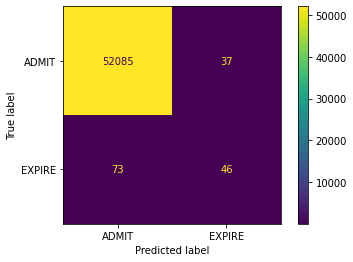

In [171]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, preds), display_labels = ["ADMIT","EXPIRE"])
disp.plot()

In [157]:
import shap

explainer = shap.Explainer(xgb_cl)
shap_values = explainer(X_train)

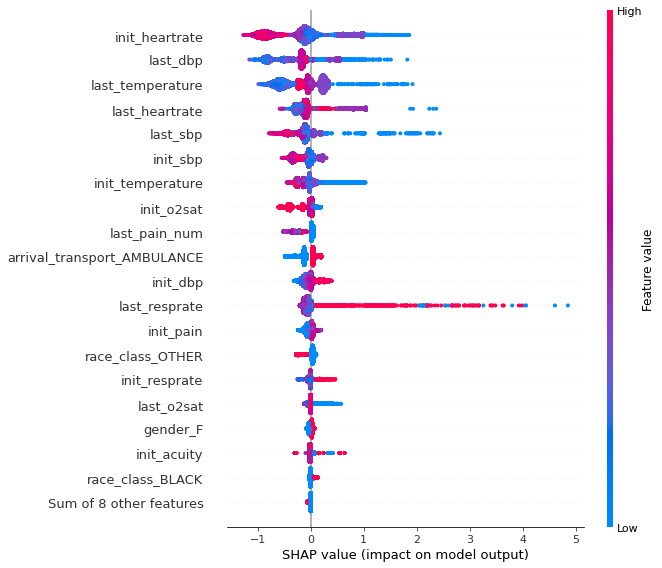

In [158]:
shap.plots.beeswarm(shap_values, max_display=20)

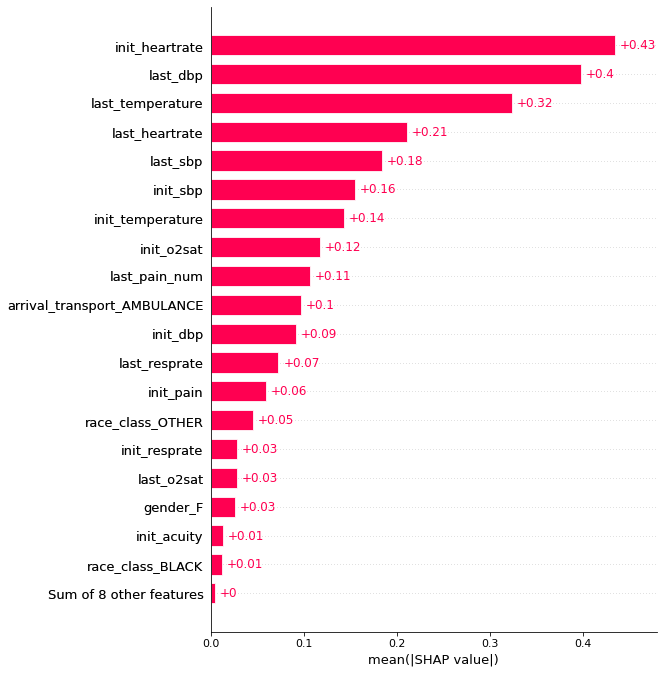

In [159]:
shap.plots.bar(shap_values, max_display=20)